# Data exploration notebook
Novartis Oncology Hackathon

Author: Long Chen

In [1]:
import pandas as pd
import re
import numpy as np
import scipy
from glob import glob
from collections import defaultdict
import csv
import pickle
import os
import datetime
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

In [814]:
patient_data = pickle.load(open('pickle files/patient_data.pkl', 'rb'))
BC_SN_code = pd.read_excel("BC_SN ICD Code.xlsx")

In [815]:
patient_data.keys()

dict_keys(['DIAG', 'PX', 'RX'])

In [816]:
patient_2l_data.keys()

dict_keys(['DIAG_2l', 'PX_2l', 'RX_2l'])

In [817]:
DIAG = patient_data['DIAG']

In [818]:
BC_SN_code.rename(columns = {'diagnosis_cd':'DIAGNOSIS_CODE'}, inplace=True)

In [819]:
DIAG = pd.merge(DIAG, BC_SN_code, how='left', on='DIAGNOSIS_CODE')
DIAG.head()

,PATIENT_ID,CLAIM_ID,CLAIM_TYP_CD,SERVICE_DATE,MONTH_ID,DIAGNOSIS_CODE,DIAG_VERS_TYP_ID,DIAG_CD_POSN_NBR,PROVIDER_ID,FLEXIBLE_FLD_1_CHAR,indication_cd,version,sub_indication_cd
0,999944505,10458194885000421223,P,12/12/2019,201912,C50.111,2,1,7976755,1.588637e+09,BC,ICD_10,NaN
1,999944505,10458181473000479341,P,09/10/2019,201909,C50.111,2,1,7976755,1.588637e+09,BC,ICD_10,NaN
2,999944505,10458165065000341912,P,05/20/2019,201905,C50.111,2,1,7976755,1.588637e+09,BC,ICD_10,NaN
3,999944505,10458161262800585500,P,05/20/2019,201905,C50.111,2,1,8117971,1.285667e+09,BC,ICD_10,NaN
4,999944505,10458157449200367497,P,02/21/2019,201902,C50.111,2,1,7976755,1.588637e+09,BC,ICD_10,NaN


In [821]:
DIAG['SERVICE_DATE'] = pd.to_datetime(DIAG['SERVICE_DATE'], format="%m/%d/%Y")

In [822]:
BC_patient = DIAG.loc[DIAG['indication_cd'] == 'BC']
MBC_patient = DIAG.loc[DIAG['indication_cd'] == 'SN']

In [823]:
uniq_BC_patient = BC_patient.groupby('PATIENT_ID')[['SERVICE_DATE']].agg("min")
uniq_BC_patient.reset_index(inplace=True)

uniq_BC_patient.head()

,PATIENT_ID,SERVICE_DATE
0,29388541,2017-02-06
1,29406345,2016-12-12
2,29437465,2018-06-18
3,29457775,2017-04-19
4,29460978,2013-12-16


In [14]:
uniq_MBC_patient = MBC_patient.groupby('PATIENT_ID')[['SERVICE_DATE']].agg("min")
uniq_MBC_patient.reset_index(inplace=True)

uniq_MBC_patient.head()

,PATIENT_ID,SERVICE_DATE
0,29437465,2018-06-18
1,29544598,2014-05-29
2,29581050,2016-12-08
3,29613658,2019-11-08
4,29632133,2018-03-15


In [15]:
BC_MBC_patient = pd.merge(uniq_BC_patient, uniq_MBC_patient, how='left', on='PATIENT_ID')
BC_MBC_patient.head()

,PATIENT_ID,SERVICE_DATE_x,SERVICE_DATE_y
0,29388541,2017-02-06,NaT
1,29406345,2016-12-12,NaT
2,29437465,2018-06-18,2018-06-18
3,29457775,2017-04-19,NaT
4,29460978,2013-12-16,NaT


In [19]:
#filter the rows with MBC is diagnosed and the date difference >= -30
filter = np.where(np.logical_or(pd.isnull(BC_MBC_patient['SERVICE_DATE_y'])==0, BC_MBC_patient['SERVICE_DATE_y']-BC_MBC_patient['SERVICE_DATE_x']>=datetime.timedelta(-30)))

MBC = BC_MBC_patient.iloc[filter]

MBC = MBC.rename(columns = {'SERVICE_DATE_x':'first_BC_date', 'SERVICE_DATE_y':'first_MBC_date'})
MBC.head()

,PATIENT_ID,first_BC_date,first_MBC_date
2,29437465,2018-06-18,2018-06-18
11,29544598,2014-05-19,2014-05-29
14,29581050,2016-12-08,2016-12-08
16,29613658,2016-07-20,2019-11-08
18,29632133,2015-01-08,2018-03-15


In [20]:
BC = uniq_BC_patient
BC.rename(columns = {'SERVICE_DATE': 'first_BC_date'}, inplace=True)
BC.head()

,PATIENT_ID,first_BC_date
0,29388541,2017-02-06
1,29406345,2016-12-12
2,29437465,2018-06-18
3,29457775,2017-04-19
4,29460978,2013-12-16


In [21]:
print('MBC shape', MBC.shape, ' BC shape', BC.shape)

MBC shape (8825, 3)  BC shape (19911, 2)


In [22]:
MBC['indicator'] = 1
MBC.head()

,PATIENT_ID,first_BC_date,first_MBC_date,indicator
2,29437465,2018-06-18,2018-06-18,1
11,29544598,2014-05-19,2014-05-29,1
14,29581050,2016-12-08,2016-12-08,1
16,29613658,2016-07-20,2019-11-08,1
18,29632133,2015-01-08,2018-03-15,1


In [23]:
DIAG_BC = DIAG[DIAG['PATIENT_ID'].isin(BC['PATIENT_ID'])]

In [25]:
DIAG_MBC = pd.merge(DIAG_BC, MBC[['PATIENT_ID','indicator']], how='left', on='PATIENT_ID')
DIAG_MBC = pd.merge(DIAG_MBC, BC, how='left', on='PATIENT_ID')
DIAG_MBC.loc[pd.isnull(DIAG_MBC['indicator']), 'indicator'] = 0

DIAG_MBC = DIAG_MBC.drop(columns = ['indication_cd', 'sub_indication_cd', 'version', 'DIAG_CD_POSN_NBR', 'CLAIM_TYP_CD', 'DIAG_VERS_TYP_ID'])
DIAG_MBC.head()

,PATIENT_ID,CLAIM_ID,SERVICE_DATE,MONTH_ID,DIAGNOSIS_CODE,PROVIDER_ID,FLEXIBLE_FLD_1_CHAR,indicator,first_BC_date
0,999944505,10458194885000421223,2019-12-12,201912,C50.111,7976755,1.588637e+09,0.0,2017-10-05
1,999944505,10458181473000479341,2019-09-10,201909,C50.111,7976755,1.588637e+09,0.0,2017-10-05
2,999944505,10458165065000341912,2019-05-20,201905,C50.111,7976755,1.588637e+09,0.0,2017-10-05
3,999944505,10458161262800585500,2019-05-20,201905,C50.111,8117971,1.285667e+09,0.0,2017-10-05
4,999944505,10458157449200367497,2019-02-21,201902,C50.111,7976755,1.588637e+09,0.0,2017-10-05


In [26]:
label = DIAG_MBC.groupby('PATIENT_ID')['indicator'].mean()

num_service = DIAG_MBC.groupby('PATIENT_ID')['SERVICE_DATE'].nunique()
num_service = num_service.reset_index()

service_time = pd.merge(num_service, label, how='left', on='PATIENT_ID')
service_time = service_time.rename(columns = {'SERVICE_DATE':'service_time', 'indicator':'label'})
service_time.head()

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

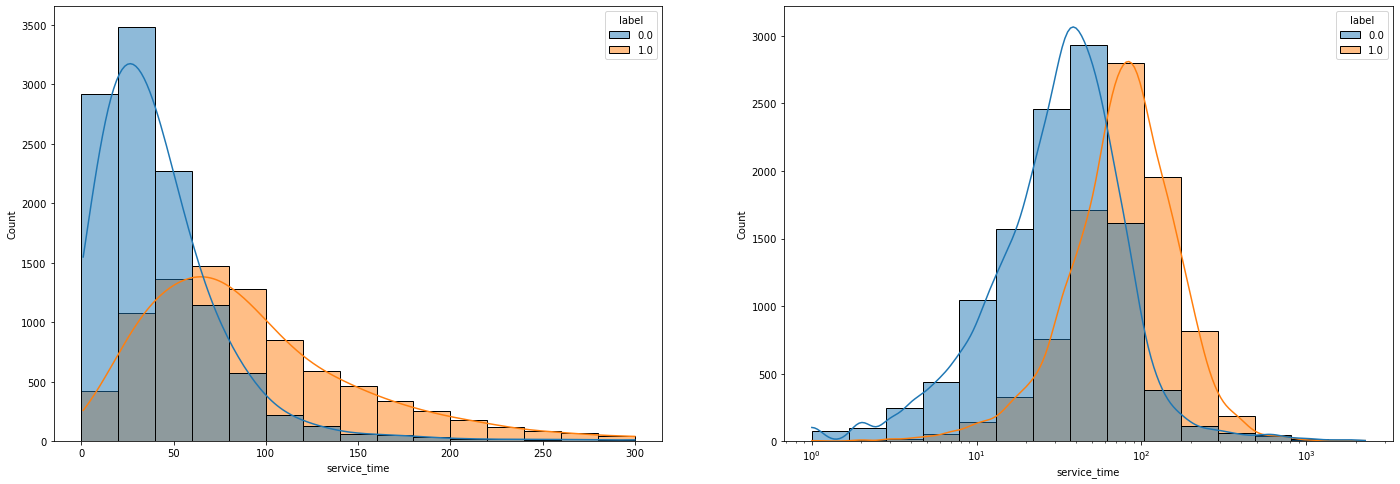

In [30]:
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(24,8)) 
sns.histplot(data=service_time, x="service_time", hue='label', bins=15, binrange=(0, 300), kde=True, kde_kws={'clip':(0, 300)}, ax=ax1)
sns.histplot(data=service_time, x="service_time", hue='label', log_scale=True, bins=15, kde=True, kde_kws={'clip':(0, 300)}, ax=ax2)
plt.show()

In [50]:
service_freq = pd.merge(service_time, BC, how='left', on='PATIENT_ID')
service_freq['num_month'] = (pd.to_datetime("2020-01-01").year-service_freq['first_BC_date'].dt.year) * 12 + pd.to_datetime("2020-01-01").month - service_freq['first_BC_date'].dt.month
service_freq['visit_per_month'] = service_freq['service_time']/service_freq['num_month']

service_freq.head()

,PATIENT_ID,service_time,label,first_BC_date,num_month,visit_per_month
0,29388541,73,0.0,2017-02-06,35,2.085714
1,29406345,42,0.0,2016-12-12,37,1.135135
2,29437465,34,1.0,2018-06-18,19,1.789474
3,29457775,39,0.0,2017-04-19,33,1.181818
4,29460978,6,0.0,2013-12-16,73,0.082192


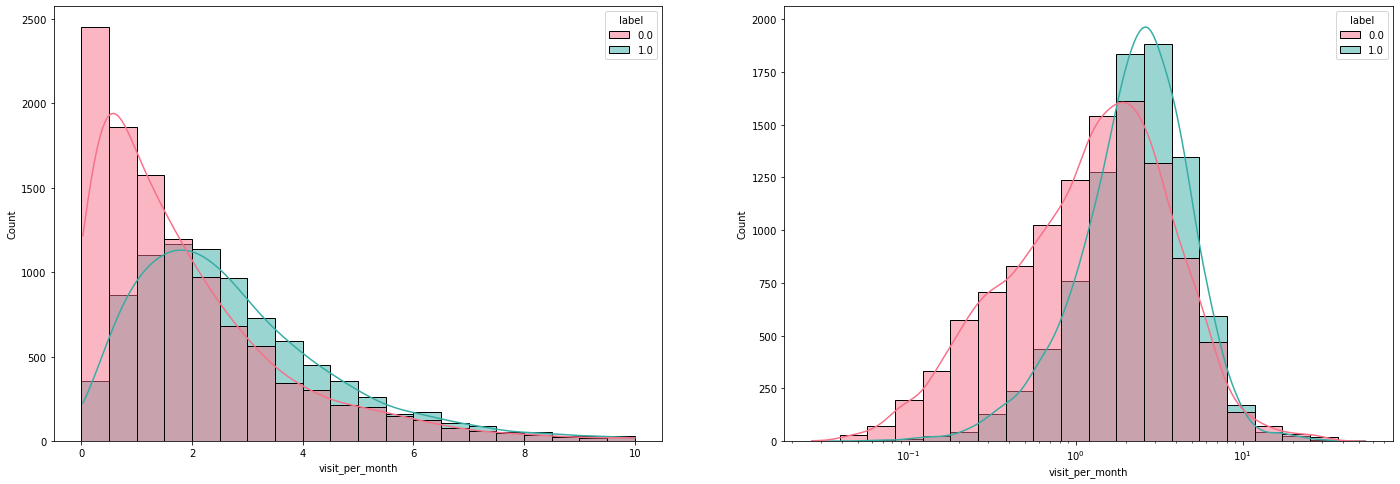

In [34]:
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(24,8)) 
sns.histplot(data=service_freq, x="visit_per_month", hue='label', bins=20, binrange=(0, 10), kde=True, kde_kws={'clip':(0, 10)}, palette="husl", ax=ax1)
sns.histplot(data=service_freq, x="visit_per_month", hue='label', bins=20, kde=True, log_scale=True, palette="husl", ax=ax2)
plt.show()

In [35]:
service_freq.groupby('label').median()

,PATIENT_ID,service_time,num_month,visit_per_month
label,,,,
0.0,707655992.5,34.0,26.0,1.363636
1.0,742535274.0,80.0,38.0,2.395349


In [66]:
diag_norm = service_freq[['PATIENT_ID','service_time', 'visit_per_month', 'label']]

diag_norm['log_times'] = np.log(diag_norm['service_time'])
diag_norm['log_freq'] =  np.log(diag_norm['visit_per_month'])

min_max_scaler = preprocessing.MinMaxScaler()
diag_norm['log_times'] = min_max_scaler.fit_transform(np.array(diag_norm['log_times']).reshape(-1, 1))
diag_norm['log_freq'] = min_max_scaler.fit_transform(np.array(diag_norm['log_freq']).reshape(-1,1))

diag_norm = diag_norm.drop(columns = ['service_time', 'visit_per_month'])

diag_norm.head()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PATIENT_ID,label,log_times,log_freq
0,29388541,0.0,0.554744,0.573177
1,29406345,0.0,0.483270,0.493432
2,29437465,1.0,0.455948,0.553096
3,29457775,0.0,0.473688,0.498715
4,29460978,0.0,0.231669,0.149286


In [40]:
Rx = pickle.load(open('pickle files/patient_rx_data.pkl'), 'rb')
Rx.head()

,CLAIM_ID,PATIENT_ID,NDC,PROVIDER_ID,DIAGNOSIS_CODE,DIAG_VERS_TYP_ID,REFILL_CODE,DSPNSD_QTY,DAYS_SUPPLY,SERVICE_DATE,DRUG_NAME,DRUG_GENERIC_NAME,DRUG_BRAND
0,5.068708e+11,29388541,59746000314,8032727,NaN,NaN,0,20.0,10,11/07/2018,METHYLPREDNISOLONE,METHYLPREDNISOLONE,OTHERS
1,5.072368e+11,29388541,69097031602,8511951,NaN,NaN,0,90.0,90,11/27/2018,EXEMESTANE,EXEMESTANE,AL
2,5.094995e+11,29388541,68001015504,9078580,NaN,NaN,1,30.0,60,09/09/2019,ANASTROZOLE,ANASTROZOLE,AL
3,5.020478e+11,29388541,16729003410,10315194,NaN,NaN,0,90.0,90,08/15/2017,LETROZOLE,LETROZOLE,LET
4,5.040118e+11,29388541,93762056,10315194,NaN,NaN,2,90.0,90,02/07/2018,LETROZOLE,LETROZOLE,LET


In [180]:
pat_drug_usage = Rx.loc[Rx['DRUG_BRAND'] != "OTHERS"].groupby(['PATIENT_ID', 'DRUG_BRAND'], as_index=False).count()
pat_drug_usage = pat_drug_usage[['PATIENT_ID', 'DRUG_BRAND', 'CLAIM_ID']].rename(columns={'CLAIM_ID': 'DRUG_USAGE'})
pat_drug_usage

,PATIENT_ID,DRUG_BRAND,DRUG_USAGE
0,29388541,AL,6
1,29388541,LET,5
2,29406345,AL,4
3,29406345,LET,10
4,29437465,AL,4
...,...,...,...
18846,1734582820,AL,1
18847,1734610805,AL,7
18848,1734656846,TAM,14
18849,1734666411,LET,70


In [181]:
total_drug_usage = pat_drug_usage.groupby('DRUG_BRAND').sum()['DRUG_USAGE']

In [199]:
bc_drug_usage = pd.merge(diag_norm, pat_drug_usage, how='right', on='PATIENT_ID')
bc_drug_usage = bc_drug_usage.loc[bc_drug_usage['label'] == 0.0].groupby('DRUG_BRAND').sum()
bc_drug_usage = bc_drug_usage[['label', 'DRUG_USAGE']].reset_index() \
                .drop(columns = 'label')

mbc_drug_usage = pd.merge(diag_norm, pat_drug_usage, how='right', on='PATIENT_ID')
mbc_drug_usage = mbc_drug_usage.loc[mbc_drug_usage['label'] == 1.0].groupby('DRUG_BRAND').sum()
mbc_drug_usage = mbc_drug_usage[['label', 'DRUG_USAGE']].reset_index() \
                 .drop(columns = 'label')


In [200]:
bc_drug_usage['label'] = 'BC'
mbc_drug_usage['label'] = 'MBC'
drug_total = pd.concat([bc_drug_usage, mbc_drug_usage])

In [201]:
drug_total = pd.merge(drug_total, total_drug_usage, how='left', on='DRUG_BRAND')
drug_total['usage_pct'] = drug_total['DRUG_USAGE_x']/drug_total['DRUG_USAGE_y']
drug_total

,DRUG_BRAND,DRUG_USAGE_x,label,DRUG_USAGE_y,usage_pct
0,AFI,21,BC,2080,0.010096
1,AL,48593,BC,88765,0.547434
2,FAS,19,BC,366,0.051913
3,IBR,457,BC,15392,0.029691
4,KIS,38,BC,755,0.050331
5,LET,21364,BC,50824,0.420353
6,TAM,20896,BC,37810,0.552658
7,VER,11,BC,948,0.011603
8,XEL,706,BC,9422,0.074931
9,AFI,2059,MBC,2080,0.989904


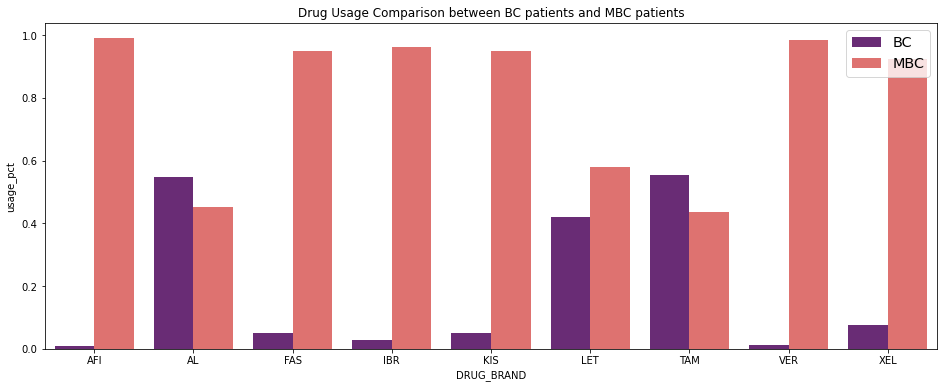

In [202]:
plt.figure(figsize=(16, 6))
sns.barplot(x='DRUG_BRAND', y ='usage_pct', hue='label', data=drug_total, palette = 'magma')
plt.legend(fontsize='x-large', title_fontsize='20')
plt.title("Drug Usage Comparison between BC patients and MBC patients")
plt.show()

- AFI, FAS, IBR, KIS, VER, XEL
- these are the 6 drugs that can be most predictive for MBC

### Only the 6 informative drug brand

In [296]:
def drug_dummy_table():
    all_patient = diag_norm[['PATIENT_ID', 'label']]
    mbc_drug = ['AFI', 'FAS', 'IBR', 'KIS', 'VER', 'XEL']
    for i in mbc_drug:
        drug_i_usage = pat_drug_usage.loc[pat_drug_usage['DRUG_BRAND'] == i][['PATIENT_ID', 'DRUG_USAGE']].rename(columns = {'DRUG_USAGE': ''.join(i)})
        all_patient = pd.merge(all_patient, drug_i_usage, how="left", on='PATIENT_ID')
    all_patient.fillna(0, inplace=True)
    return all_patient

In [299]:
drug_dummy = drug_dummy_table()
drug_dummy.drop(columns='label', inplace=True)
drug_dummy.head()

,PATIENT_ID,AFI,FAS,IBR,KIS,VER,XEL
0,29388541,0.0,0.0,0.0,0.0,0.0,0.0
1,29406345,0.0,0.0,0.0,0.0,0.0,0.0
2,29437465,0.0,0.0,0.0,0.0,0.0,0.0
3,29457775,0.0,0.0,0.0,0.0,0.0,0.0
4,29460978,0.0,0.0,0.0,0.0,0.0,0.0


### Take all drug brand into account

In [611]:
def drug_full_dummy_table():
    all_patient = diag_norm[['PATIENT_ID', 'label']]
    mbc_drug = ['AFI', 'AL', 'FAS', 'IBR', 'KIS', 'LET', 'TRM', 'VER', 'XEL']
    for i in mbc_drug:
        drug_i_usage = pat_drug_usage.loc[pat_drug_usage['DRUG_BRAND'] == i][['PATIENT_ID', 'DRUG_USAGE']].rename(columns = {'DRUG_USAGE': ''.join(i)})
        all_patient = pd.merge(all_patient, drug_i_usage, how="left", on='PATIENT_ID')
    all_patient.fillna(0, inplace=True)
    return all_patient

In [633]:
drug_full = drug_full_dummy_table()
drug_full.head()

,PATIENT_ID,label,AFI,AL,FAS,IBR,KIS,LET,TRM,VER,XEL
0,29388541,0.0,0.0,6.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
1,29406345,0.0,0.0,4.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
2,29437465,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29457775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,29460978,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Normalization

In [305]:
min_max_scaler = preprocessing.MinMaxScaler()
for i in drug_dummy.columns[1:]:
    drug_dummy[i] = min_max_scaler.fit_transform(np.array(drug_dummy[i]).reshape(-1, 1))

no_proc = pd.merge(diag_norm, drug_dummy, how='left', on ='PATIENT_ID')
no_proc.set_index('PATIENT_ID', inplace=True)

In [306]:
no_proc.head()

,label,log_times,log_freq,AFI,FAS,IBR,KIS,VER,XEL
PATIENT_ID,,,,,,,,,
29388541,0.0,0.554744,0.573177,0.0,0.0,0.0,0.0,0.0,0.0
29406345,0.0,0.483270,0.493432,0.0,0.0,0.0,0.0,0.0,0.0
29437465,1.0,0.455948,0.553096,0.0,0.0,0.0,0.0,0.0,0.0
29457775,0.0,0.473688,0.498715,0.0,0.0,0.0,0.0,0.0,0.0
29460978,0.0,0.231669,0.149286,0.0,0.0,0.0,0.0,0.0,0.0


In [634]:
min_max_scaler = preprocessing.MinMaxScaler()
for i in drug_full.columns[1:]:
    drug_full[i] = min_max_scaler.fit_transform(np.array(drug_full[i]).reshape(-1, 1))

alldrug_no_proc = pd.merge(diag_norm, drug_full.drop(columns = 'label'), how='left', on ='PATIENT_ID')
alldrug_no_proc.set_index('PATIENT_ID', inplace=True)

In [635]:
alldrug_no_proc.head()

,label,log_times,log_freq,AFI,AL,FAS,IBR,KIS,LET,TRM,VER,XEL
PATIENT_ID,,,,,,,,,,,,
29388541,0.0,0.554744,0.573177,0.0,0.068966,0.0,0.0,0.0,0.055556,0.0,0.0,0.0
29406345,0.0,0.483270,0.493432,0.0,0.045977,0.0,0.0,0.0,0.111111,0.0,0.0,0.0
29437465,1.0,0.455948,0.553096,0.0,0.045977,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
29457775,0.0,0.473688,0.498715,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
29460978,0.0,0.231669,0.149286,0.0,0.068966,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [68]:
Px = pickle.load(open('pickle files/patient_px_data.pkl'), 'rb')
Px.head()

,PATIENT_ID,CLAIM_ID,CLAIM_LINE_ITEM,PROCEDURE_CODE,PRC1_MOD_CD,PRC1_MOD_DESC,SVC_CRGD_AMT,SERVICE_DATE,UNIT_OF_SVC_AMT,PLACE_OF_SERVICE,PAY_TYPE,NDC,DIAGNOSIS_CODE,DIAG_CD_POSN_NBR,DIAG_VERS_TYP_ID,PRC_STD_CD,PRC_TYP_CD,PROCEDURE_DESCRIPTION,PRC_DOSAGE_AMT,PRC_DOSAGE_UOM
0,29360529,10364181442207512163,2,80053,NaN,NaN,64.0,10/18/2019,1.0,NaN,THIRD PARTY,NaN,C79.51,1,2,80053,C,COMPREHENSIVE METABOLIC PANEL THIS PANEL MUST ...,NaN,NaN
1,29360529,10364181442208031376,0,NaN,NaN,NaN,NaN,10/18/2019,NaN,NaN,NaN,NaN,C78.7,5,2,NaN,NaN,NaN,NaN,NaN
2,29360529,10364181442208031376,1,J1100,NaN,NaN,10.0,10/18/2019,10.0,NaN,THIRD PARTY,6.33231e+10,C50.412,1,2,J1100,H,"INJECTION, DEXAMETHASONE SODIUM PHOSPHATE, 1 MG",1.0,MG
3,29360529,10364181442208031376,1,J1100,NaN,NaN,10.0,10/18/2019,10.0,NaN,THIRD PARTY,6.33231e+10,C79.51,4,2,J1100,H,"INJECTION, DEXAMETHASONE SODIUM PHOSPHATE, 1 MG",1.0,MG
4,29360529,10364181442208031376,1,J1100,NaN,NaN,10.0,10/18/2019,10.0,NaN,THIRD PARTY,6.33231e+10,Z17.0,2,2,J1100,H,"INJECTION, DEXAMETHASONE SODIUM PHOSPHATE, 1 MG",1.0,MG


In [730]:
proc_times = Px.loc[Px['PROCEDURE_CODE'].isna() == False].groupby(['PATIENT_ID', 'PROCEDURE_CODE'], as_index=False).count()

In [731]:
proc_times = proc_times[['PATIENT_ID', 'PROCEDURE_CODE', 'CLAIM_ID']].rename(columns={'CLAIM_ID': 'PROC_TIMES'})
proc_times

,PATIENT_ID,PROCEDURE_CODE,PROC_TIMES
0,29360529,00402,2
1,29360529,36415,26
2,29360529,36589,1
3,29360529,71250,2
4,29360529,71260,6
...,...,...,...
1375608,5236974200,J2405,1
1375609,5236974200,J3010,2
1375610,5236974200,J7030,1
1375611,5236974200,J8999,4


In [732]:
total_proc_times = proc_times.groupby('PROCEDURE_CODE').sum()['PROC_TIMES']

In [223]:
mbc_proc_times = pd.merge(diag_norm, proc_times, how='left', on='PATIENT_ID')
mbc_proc_times = mbc_proc_times.loc[mbc_proc_times['label'] == 1.0].groupby('PROCEDURE_CODE').sum()
mbc_proc_times = mbc_proc_times[['label', 'PROC_TIMES']].reset_index() \
                 .drop(columns = 'label')

bc_proc_times = pd.merge(diag_norm, proc_times, how='left', on='PATIENT_ID')
bc_proc_times = bc_proc_times.loc[bc_proc_times['label'] == 0.0].groupby('PROCEDURE_CODE').sum()
bc_proc_times = bc_proc_times[['label', 'PROC_TIMES']].reset_index() \
                 .drop(columns = 'label')

### Select 500 most common procedures

In [733]:
#all_patient = diag_norm[['PATIENT_ID']]
def top_500_proc(data):
    all_patient = diag_norm[['PATIENT_ID', 'label']]
    top_100 = data.sort_values('PROC_TIMES', ascending=False)[:500]
    for i in range(500):
        proc_i = top_100.iloc[i]['PROCEDURE_CODE']
        proc_i_times = pat_proc_times.loc[pat_proc_times['PROCEDURE_CODE'] == proc_i][['PROC_TIMES', 'PATIENT_ID']].rename(columns = {'PROC_TIMES': ''.join(proc_i)})
        all_patient = pd.merge(all_patient, proc_i_times, how="left", on='PATIENT_ID')
    all_patient.fillna(0, inplace=True)
    return all_patient

In [734]:
proc_dummy = top_500_proc(proc)
proc_dummy.set_index("PATIENT_ID", inplace=True)
proc_dummy.head()

,label,85025,80053,96413,99214,36415,J1100,96375,86300,J9395,...,Q2051,J0171,84157,82570,99221,Q5106,C9463,82533,97016,76882
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
29388541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29406345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29437465,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29457775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29460978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Using PCA to subset the procedures

In [736]:
stdscaler = preprocessing.StandardScaler()
x = proc_dummy.iloc[:, 1:].values
y = proc_dummy.iloc[:, 0].values
x = stdscaler.fit_transform(x)

pca = PCA(0.9)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
n_components = pca.n_components_
print('{} principal components explained 90% of the variation in procedure'.format(n_components))

224 principal components explained 90% of the variation in procedure


### Manual Procedure Selection (RandomForest feature importance)

In [737]:
min_max_scaler = preprocessing.MinMaxScaler()
for i in proc_dummy.columns[1:]:
    proc_dummy[i] = min_max_scaler.fit_transform(np.array(proc_dummy[i]).reshape(-1, 1))

In [738]:
#using all 500 features
X, y = proc_dummy.iloc[:, 1:], proc_dummy.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 60.48


In [741]:
# feature selection
def select_features(X_train, y_train, X_test, n_features):
	# configure to select a subset of features
	fs = SelectFromModel(RandomForestClassifier(n_estimators=1000), max_features=n_features)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

X, y = proc_dummy.iloc[:, 1:], proc_dummy.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model_accuracy = []
for i in range(1,21):
    print(f"number of procedures selected:{i}")
    X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, i)
    # fit the model
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train_fs, y_train)
    # evaluate the model
    yhat = model.predict(X_test_fs)
    # evaluate predictions
    accuracy = accuracy_score(y_test, yhat)
    model_accuracy.append(accuracy)
    print(f'Accuracy: %.2f' % (accuracy*100))

number of procedures selected:1
Accuracy: 58.47
number of procedures selected:2
Accuracy: 59.73
number of procedures selected:3
Accuracy: 60.14
number of procedures selected:4
Accuracy: 60.24
number of procedures selected:5
Accuracy: 60.33
number of procedures selected:6
Accuracy: 60.34
number of procedures selected:7
Accuracy: 60.36
number of procedures selected:8
Accuracy: 60.36
number of procedures selected:9
Accuracy: 60.40
number of procedures selected:10
Accuracy: 60.41
number of procedures selected:11
Accuracy: 60.41
number of procedures selected:12
Accuracy: 60.41
number of procedures selected:13
Accuracy: 60.41
number of procedures selected:14
Accuracy: 60.46
number of procedures selected:15
Accuracy: 60.46
number of procedures selected:16
Accuracy: 60.46
number of procedures selected:17
Accuracy: 60.48
number of procedures selected:18
Accuracy: 60.46
number of procedures selected:19
Accuracy: 60.48
number of procedures selected:20
Accuracy: 60.50


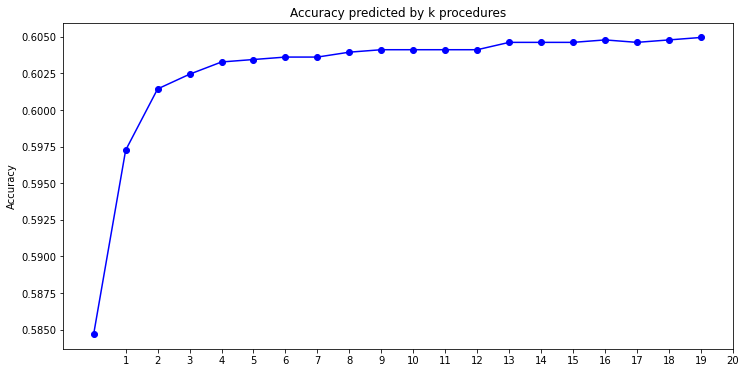

In [745]:
plt.figure(figsize=(12, 6))
plt.plot(model_accuracy, 'bo-')
plt.title("Accuracy predicted by k procedures")
plt.xticks(ticks = range(1, 21), label='k')
plt.ylabel('Accuracy')
plt.show()

In [748]:
fs = SelectFromModel(RandomForestClassifier(n_estimators=1000), max_features=11)
fs.fit(X_train, y_train)

selected_features = X.columns[fs.get_support() == True]
proc_top11 = proc_dummy[selected_features]

### Build the training and testing set

- feature candidate 1: service_times, service_frequency, 6 drugs and 11 manually selected procedures(using 

In [756]:
drug6_proc11 = pd.merge(no_proc, proc_top11, how='left', on='PATIENT_ID')
drug6_proc11 = drug6_proc11.reset_index().drop(columns = "PATIENT_ID")
drug6_proc11.head()

,label,log_times,log_freq,AFI,FAS,IBR,KIS,VER,XEL,85025,80053,96413,99214,36415,J1100,96375,99213,99215,88305,77300
0,0.0,0.554744,0.573177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.483270,0.493432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.455948,0.553096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.473688,0.498715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.231669,0.149286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- feature candidate 2: service_time, service_frequency, 6 drugs and PCA selected procedures

In [750]:
drug6_pca_proc = pd.concat([no_proc.reset_index().drop(columns = 'PATIENT_ID'), principalDf], axis=1)
drug6_pca_proc.head()

,label,log_times,log_freq,AFI,FAS,IBR,KIS,VER,XEL,0,...,214,215,216,217,218,219,220,221,222,223
0,0.0,0.554744,0.573177,0.0,0.0,0.0,0.0,0.0,0.0,-1.341386,...,-0.007425,-0.000476,0.001567,0.004736,0.003507,-0.001559,-0.004053,0.003264,0.003744,0.001415
1,0.0,0.483270,0.493432,0.0,0.0,0.0,0.0,0.0,0.0,-1.341386,...,-0.007425,-0.000476,0.001567,0.004736,0.003507,-0.001559,-0.004053,0.003264,0.003744,0.001415
2,1.0,0.455948,0.553096,0.0,0.0,0.0,0.0,0.0,0.0,-1.341386,...,-0.007425,-0.000476,0.001567,0.004736,0.003507,-0.001559,-0.004053,0.003264,0.003744,0.001415
3,0.0,0.473688,0.498715,0.0,0.0,0.0,0.0,0.0,0.0,-1.341386,...,-0.007425,-0.000476,0.001567,0.004736,0.003507,-0.001559,-0.004053,0.003264,0.003744,0.001415
4,0.0,0.231669,0.149286,0.0,0.0,0.0,0.0,0.0,0.0,-1.341386,...,-0.007425,-0.000476,0.001567,0.004736,0.003507,-0.001559,-0.004053,0.003264,0.003744,0.001415


- feature candidate 3: service_time, service_frequency, all drugs and PCA selected procedures

In [641]:
alldrug_pca_proc = pd.concat([alldrug_no_proc.reset_index().drop(columns = 'PATIENT_ID'), principalDf], axis=1)
alldrug_pca_proc.head()

,label,log_times,log_freq,AFI,AL,FAS,IBR,KIS,LET,TRM,...,214,215,216,217,218,219,220,221,222,223
0,0.0,0.554744,0.573177,0.0,0.068966,0.0,0.0,0.0,0.055556,0.0,...,-0.007425,-0.000476,0.001567,0.004736,0.003507,-0.001559,-0.004053,0.003264,0.003744,0.001415
1,0.0,0.483270,0.493432,0.0,0.045977,0.0,0.0,0.0,0.111111,0.0,...,-0.007425,-0.000476,0.001567,0.004736,0.003507,-0.001559,-0.004053,0.003264,0.003744,0.001415
2,1.0,0.455948,0.553096,0.0,0.045977,0.0,0.0,0.0,0.000000,0.0,...,-0.007425,-0.000476,0.001567,0.004736,0.003507,-0.001559,-0.004053,0.003264,0.003744,0.001415
3,0.0,0.473688,0.498715,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,-0.007425,-0.000476,0.001567,0.004736,0.003507,-0.001559,-0.004053,0.003264,0.003744,0.001415
4,0.0,0.231669,0.149286,0.0,0.068966,0.0,0.0,0.0,0.000000,0.0,...,-0.007425,-0.000476,0.001567,0.004736,0.003507,-0.001559,-0.004053,0.003264,0.003744,0.001415


### Model Candidates: Logistic Regression, XGBoost, SVM, RandomForest, Neural Network
- Run each model on all 3 feature candidates, and measure the model's performance using the AUC score
- K-fold Cross Validation to get the average AUC score
- Select the best combination of model and feature

#### Model on feature candidate 1:

In [793]:
model_performance = {'feature1':[], 'feature2':[], 'feature3':[]}

In [794]:
def model_Kfold_auc(X, y, model):
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    kf.get_n_splits(X)

    auc = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        model.fit(X_train, y_train)
        yhat = model.predict_proba(X_test)
        auc_i = (roc_auc_score(y_test, yhat[:, 1]))    
        auc.append(auc_i)
    return np.mean(auc)

In [795]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
X, y = drug6_proc11.iloc[:, 1:], drug6_proc11.iloc[:, 0]

In [796]:
for i in [XGBClassifier(), LogisticRegression(solver='liblinear'),  svm.SVC(kernel='rbf',probability=True), RandomForestClassifier(n_estimators=2000)]:
    model_performance['feature1'].append(model_Kfold_auc(X, y, i))

In [797]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Classifier(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(n_input,n_hidden1)
        self.fc2 = nn.Linear(n_hidden1,n_hidden2)
        self.fc3 = nn.Linear(n_hidden2,1)
    
    def forward(self,x):
        x = F.dropout(F.relu(self.fc1(x)))
        x = F.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [798]:
model = Classifier(19, 50, 25)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

model.train()
auc = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    X_train, X_test, y_train, y_test = torch.FloatTensor(X_train.to_numpy()), torch.FloatTensor(X_test.to_numpy()), torch.from_numpy(y_train.to_numpy()), torch.from_numpy(y_test.to_numpy())
    
    for e in range(500):
        epoch_loss = 0
        epoch_acc = 0
        optimizer.zero_grad()

        y_pred = model(X_train)
        loss = criterion(y_pred.squeeze(), y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    y_predict = model(X_test)
    test_loss = criterion(y_predict.squeeze(), y_test)
    auc_i = roc_auc_score(y_test.detach().numpy(), y_predict.detach().numpy())
    auc.append(auc_i)
    print(f'Epoch {e} | AUC: {auc}')

avg_auc = np.mean(auc)
print(f'Neural Network AUC: {avg_auc}')
model_performance['feature1'].append(avg_auc)

Epoch 499 | AUC: [0.8150046153193867]
Epoch 499 | AUC: [0.8150046153193867, 0.8079624245249647]
Epoch 499 | AUC: [0.8150046153193867, 0.8079624245249647, 0.8173107579492085]
Epoch 499 | AUC: [0.8150046153193867, 0.8079624245249647, 0.8173107579492085, 0.8292314837796712]
Epoch 499 | AUC: [0.8150046153193867, 0.8079624245249647, 0.8173107579492085, 0.8292314837796712, 0.8176980139816672]
Neural Network AUC: 0.8174414591109797


#### Model on feature candidate 2:

In [799]:
X, y = drug6_pca_proc.iloc[:, 1:], drug6_pca_proc.iloc[:, 0]

In [800]:
for i in [XGBClassifier(), LogisticRegression(solver='liblinear'),  svm.SVC(kernel='rbf',probability=True), RandomForestClassifier(n_estimators=2000)]:
    model_performance['feature2'].append(model_Kfold_auc(X, y, i))

In [801]:
model = Classifier(232, 150, 50)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

model.train()
auc = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    X_train, X_test, y_train, y_test = torch.FloatTensor(X_train.to_numpy()), torch.FloatTensor(X_test.to_numpy()), torch.from_numpy(y_train.to_numpy()), torch.from_numpy(y_test.to_numpy())
    
    for e in range(500):
        epoch_loss = 0
        epoch_acc = 0
        optimizer.zero_grad()

        y_pred = model(X_train)
        loss = criterion(y_pred.squeeze(), y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    y_predict = model(X_test)
    test_loss = criterion(y_predict.squeeze(), y_test)
    auc_i = roc_auc_score(y_test.detach().numpy(), y_predict.detach().numpy())
    auc.append(auc_i)
    print(f'Epoch {e} | AUC: {auc}')

avg_auc = np.mean(auc)
print(f'Neural Network AUC: {avg_auc}')
model_performance['feature2'].append(avg_auc)

Epoch 499 | AUC: [0.8237073146810066]
Epoch 499 | AUC: [0.8237073146810066, 0.8187387669224588]
Epoch 499 | AUC: [0.8237073146810066, 0.8187387669224588, 0.826477792492857]
Epoch 499 | AUC: [0.8237073146810066, 0.8187387669224588, 0.826477792492857, 0.8382026314787184]
Epoch 499 | AUC: [0.8237073146810066, 0.8187387669224588, 0.826477792492857, 0.8382026314787184, 0.8294440559512053]
Neural Network AUC: 0.8273141123052493


#### Model on feature candidate 3:

In [802]:
X, y = alldrug_pca_proc.iloc[:, 1:], alldrug_pca_proc.iloc[:, 0]

In [803]:
for i in [XGBClassifier(), LogisticRegression(solver='liblinear'),  svm.SVC(kernel='rbf',probability=True), RandomForestClassifier(n_estimators=2000)]:
    model_performance['feature3'].append(model_Kfold_auc(X, y, i))

In [804]:
model = Classifier(235, 150, 50)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

model.train()
auc = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    X_train, X_test, y_train, y_test = torch.FloatTensor(X_train.to_numpy()), torch.FloatTensor(X_test.to_numpy()), torch.from_numpy(y_train.to_numpy()), torch.from_numpy(y_test.to_numpy())
    
    for e in range(500):
        epoch_loss = 0
        epoch_acc = 0
        optimizer.zero_grad()

        y_pred = model(X_train)
        loss = criterion(y_pred.squeeze(), y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    y_predict = model(X_test)
    test_loss = criterion(y_predict.squeeze(), y_test)
    auc_i = roc_auc_score(y_test.detach().numpy(), y_predict.detach().numpy())
    auc.append(auc_i)
    print(f'Epoch {e} | AUC: {auc}')

avg_auc = np.mean(auc)
print(f'Neural Network AUC: {avg_auc}')
model_performance['feature3'].append(avg_auc)

Epoch 499 | AUC: [0.8311357567974434]
Epoch 499 | AUC: [0.8311357567974434, 0.820740529454944]
Epoch 499 | AUC: [0.8311357567974434, 0.820740529454944, 0.8277720041529223]
Epoch 499 | AUC: [0.8311357567974434, 0.820740529454944, 0.8277720041529223, 0.8389114584837748]
Epoch 499 | AUC: [0.8311357567974434, 0.820740529454944, 0.8277720041529223, 0.8389114584837748, 0.8247182401665204]
Neural Network AUC: 0.828655597811121


In [811]:
result = pd.DataFrame(
    model_performance, 
    index = ["XGBoost", 'Logistic', 'SVM', 'Random Forest', 'Neural Network'])

In [812]:
result.head()

,feature1,feature2,feature3
XGBoost,0.829128,0.829648,0.831985
Logistic,0.821832,0.822432,0.822949
SVM,0.821552,0.814228,0.814739
Random Forest,0.788351,0.788429,0.798379
Neural Network,0.817441,0.827314,0.828656


Best Threshold=0.456227, G-Mean=0.754


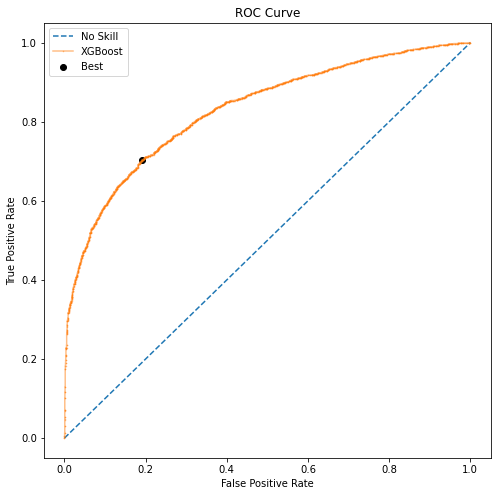

In [721]:
X, y = alldrug_pca_proc.iloc[:, 1:], alldrug_pca_proc.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# fit the model
model = XGBClassifier()
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)
# evaluate predictions
fpr, tpr, thresholds = roc_curve(y_test, yhat[:, 1])
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.figure(figsize=(8, 8))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost', alpha=0.5, markersize=1)
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
# show the plot
plt.show()

In [727]:
from sklearn.metrics import confusion_matrix

best_threshold = thresholds[ix]

X, y = alldrug_pca_proc.iloc[:, 1:], alldrug_pca_proc.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# fit the model
model = XGBClassifier()
model.fit(X_train, y_train)
#y_hat = model.predict(X_test)
y_prob= model.predict_proba(X_test)
yhat = y_prob[:, 1] >= best_threshold
# evaluate predictions

cm = confusion_matrix(y_test, yhat)
print('Confusion Matrix : \n', cm)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : %.2f'% (specificity*100))
recall = recall_score(y_test, yhat)
print('Recall(Sensitivity): %.2f' % (recall*100))
precision = precision_score(y_test, yhat)
print('Precision: %2f' % (precision*100))
f1 = f1_score(y_test, yhat)
print('F1 score: %f' % (f1*100))

Confusion Matrix : 
 [[2256  534]
 [ 649 1539]]
Accuracy: 76.24
Specificity : 80.86
Recall(Sensitivity): 70.34
Precision: 74.240232
F1 score: 72.236564
